In [ ]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F

%config InlineBackend.figure_format = 'retina'

### Load and summarize the data

In [2]:
seqs = pd.read_csv("oas_pair_heavy.csv", usecols=["cdr3_aa_heavy"])[
    "cdr3_aa_heavy"
].tolist()
seqs = list(set(seqs))
seqs[:10]

['AAPMGAVLGNYFDF',
 'ARIWCSSTSCYELEPVGIDY',
 'ARHDLSYSSFDY',
 'TAEGY',
 'ARHAASGRLLSYYYYYGMDV',
 'ARDLRSVDTAMVGAYYYYMDV',
 'ARSDYDGFYFDY',
 'ARVPLYFHLMDY',
 'AYPAGGPYYFDY',
 'ARLGNYFSYYYYGMDV']

95% CI: [6.000, 22.000]
101344 sequences, min length 2, max length 44


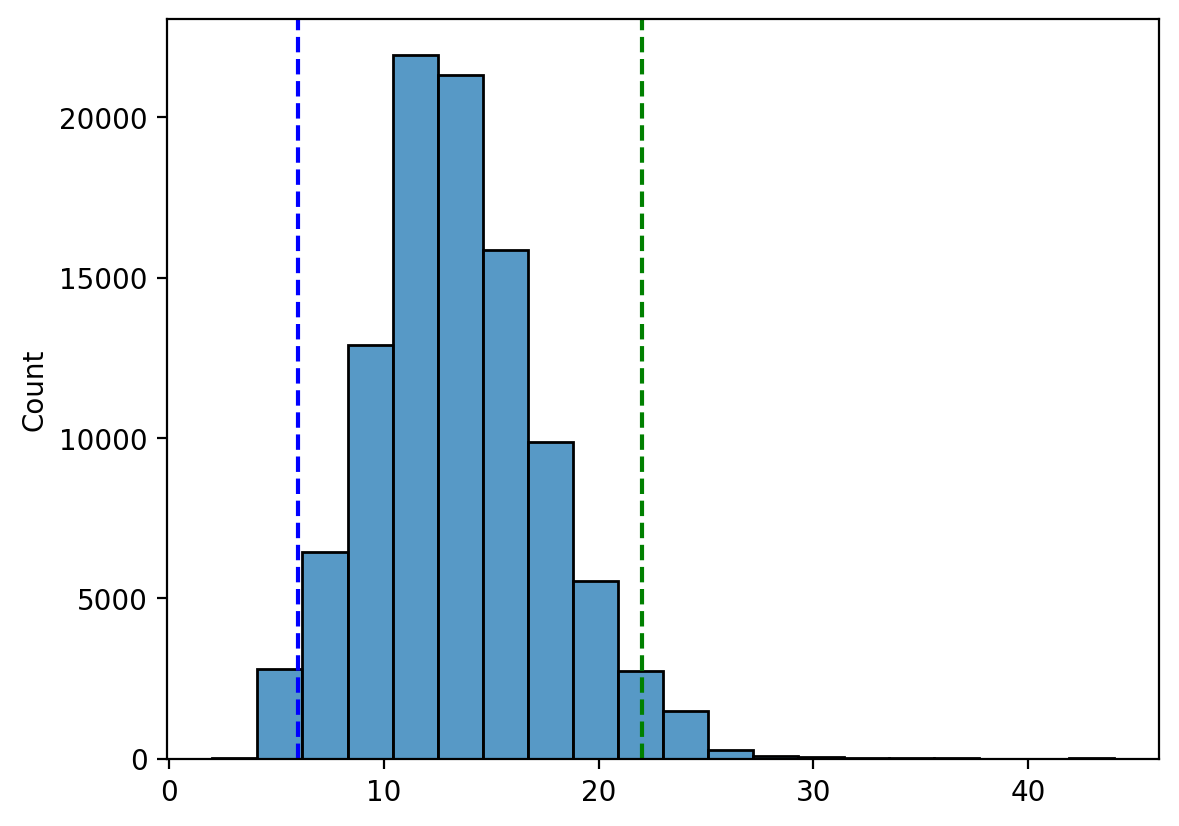

In [3]:
lengths = [len(seq) for seq in seqs]
total = len(seqs)
min_len = min(lengths)
max_len = max(lengths)
lower = np.percentile(lengths, 2.5)
upper = np.percentile(lengths, 97.5)
print(f"95% CI: [{lower:.3f}, {upper:.3f}]")
print(f"{total} sequences, min length {min_len}, max length {max_len}")
sns.histplot(lengths, bins=20, kde=False, stat="count")
plt.axvline(lower, color="blue", linestyle="--", label="2.5% (Lower)")
plt.axvline(upper, color="green", linestyle="--", label="97.5% (Upper)")
plt.show()

### Vocabulary and mapper

In [4]:
tokens = sorted(list(set("".join(seqs))))
stoi = {t: i+1 for i, t in enumerate(tokens)}
stoi['.'] = 0
itos = {i: t for t, i in stoi.items()}

### Dataset

In [5]:
def build_dataset(splits, n=3):
    X, Y = [], []
    for seq in splits:
        context = '.' * n
        seq = context + seq + '.'
        for i in range(len(seq) - n):
            input_tokens = seq[i: i+n]
            target_token = seq[i+n]
            input_ids = [stoi[token] for token in input_tokens]
            target_id = stoi[seq[i+n]]
            # print(f"{input_ids}|{input_tokens} ==> {target_id}|{target_token}")
            X.append(input_ids)
            Y.append(target_id)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [6]:
# Train,  Validation, Test
random.seed(42)
random.shuffle(seqs)
n1 = int(0.8*len(seqs))
n2 = n1 + int(0.5*(len(seqs) - n1))
X_train, Y_train = build_dataset(seqs[:n1])
X_val, Y_val = build_dataset(seqs[n1:n2])
X_test, Y_test = build_dataset(seqs[n2:])

### Hyperparameters

In [7]:
embedding_dim = 2
window_size = 3
hidden_dim = 300

steps = 10000
batch_size = 128

In [8]:
g = torch.Generator().manual_seed(222)

### Model

#### 0. How to transform one distribution into another distribution

tensor(-0.0088) tensor(0.9960)
tensor(-0.0003) tensor(1.5771)


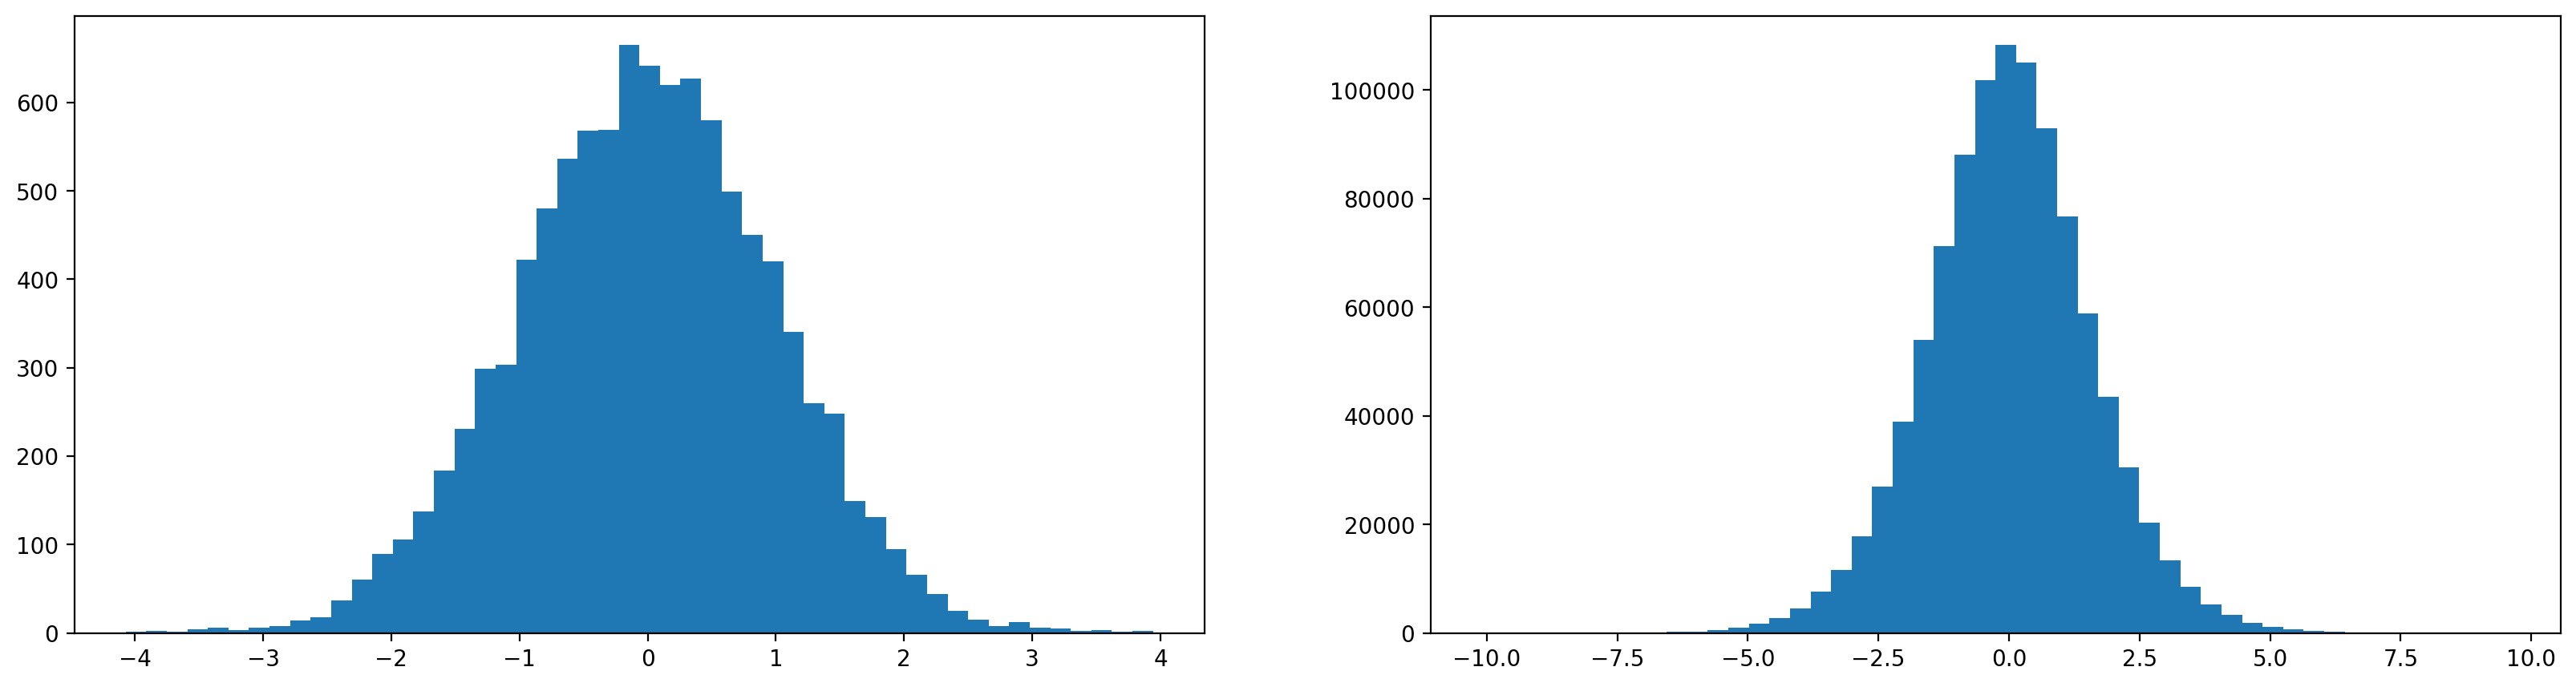

In [11]:
x = torch.randn(1000, 10)
w = torch.randn(10, 1000) * 0.5 # scale normal distribution
y = x @ w
print(x.mean() , x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50)
plt.show()

#### 1. Setup initialize weights methods

Basically, it transform original distribution by multiply by some factors into approximate gaussian distribution when applying input with certain layer weights

In [79]:
# Different activate function with different gain values (for tanh using 5/3)
# https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
init_scale = (5/3) / ((window_size * embedding_dim)**0.5)

print(f"Input Shape: [..., {window_size}]")
C = torch.randn(len(stoi), embedding_dim, generator=g)

W1 = torch.randn(window_size * embedding_dim, hidden_dim, generator=g) * init_scale
b1 = torch.randn(hidden_dim, generator=g) * 0.01

W2 = torch.randn(hidden_dim, len(stoi), generator=g) * 0.01
b2 = torch.randn(len(stoi), generator=g) * 0

bn_gain = torch.ones((1, hidden_dim))
bn_bias = torch.zeros((1, hidden_dim))

bn_mean_running = torch.zeros((1, hidden_dim)) # mean: 0 for all dim
bn_std_running = torch.ones((1, hidden_dim)) # std: 1 for all dim

print(f"Lookup Table Shape: {C.shape}")
print(f"W1 Shape: {W1.shape}, b1 Shape: {b1.shape}")
print(f"W2 Shape: {W2.shape}, b2 Shape: {b2.shape}")

Input Shape: [..., 3]
Lookup Table Shape: torch.Size([21, 2])
W1 Shape: torch.Size([6, 300]), b1 Shape: torch.Size([300])
W2 Shape: torch.Size([300, 21]), b2 Shape: torch.Size([21])


In [80]:
parameters = [C, W1, W2, b2, bn_gain, bn_bias]
print(f"Total parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
	p.requires_grad = True

Total parameters: 8763


### Training

In [81]:
def lrs_scheduler(lr_range = [0.001, 0.5]):
    # Used for find best learning rate
    min_lre = math.log10(lr_range[0])
    max_lre = math.log10(lr_range[1])
    lre = torch.linspace(min_lre, max_lre, steps)
    lrs = 10 ** lre
    return lrs

In [82]:
losses = []
learning_rates = []
track_steps = []

##### 2. Using batch normalization

In [83]:
for step in range(steps):
    indices = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[indices]
    Y_batch = Y_train[indices]
    
    # Forward
    # Embedding layer and 1st hidden layer
    embed = C[X_batch]
    h = embed.view(-1, embedding_dim * window_size) @ W1 # + b1 ignore this bias since using batch norm

    # Batch normalization
    bn_mean = h.mean(0, keepdim=True)
    bn_std = h.std(0, keepdim=True)
    h = (h - bn_mean) / bn_std
    h = bn_gain * h + bn_bias

    # Track and soft update batch normalization mean and std in training datasets
    # These values will used in test stage
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std

    # Apply activate function
    h_act = torch.tanh(h)

    # Output layer
    logits = h_act @ W2 + b2

    # Loss

    # Under the hood of cross entropy
    # probs = logits.exp()
    # probs /= probs.sum(1, keepdim=True)
    loss = F.cross_entropy(logits, Y_batch)

    for p in parameters:
        p.grad = None

    # Backward
    loss.backward()

    # lr = lrs[step] # Used for find best learning rate
    lr = 10 ** (-2)

    for p in parameters:
        p.data += -lr * p.grad
    
    losses.append(loss.item())
    track_steps.append(step) 
    
    # learning_rates.append(lre[step]) # Used for find best learning rate

    if step % 1000 == 0:
        print(f"Step: {step} | Loss: {loss.item():.4f}")

print(f"Final Loss: {loss.item()}")

Step: 0 | Loss: 3.0654
Step: 1000 | Loss: 2.3891
Step: 2000 | Loss: 2.1890
Step: 3000 | Loss: 2.3441
Step: 4000 | Loss: 2.1983
Step: 5000 | Loss: 2.1480
Step: 6000 | Loss: 2.1557
Step: 7000 | Loss: 2.1422
Step: 8000 | Loss: 1.9987
Step: 9000 | Loss: 2.0020
Final Loss: 2.0734894275665283


In [84]:
def estimate_ideal_loss(vocab_size):
	# negtive log likelihood, short for nll
	# orginal uniform probs: 1 / len(stoi)
	# transform it into log value to support sum operation
	# using negtive sign convert it from log likelihood into loss(nll)
	return -math.log(1 / vocab_size)

estimate_ideal_loss(vocab_size=len(stoi))

3.044522437723423

In [85]:
def is_near_equal(tensor, tensor_value=1e-6):
    """
    Check if all elements in a tensor are zero or very close to zero.
    
    Args:
        tensor (torch.Tensor): The tensor to check
        epsilon (float): Threshold for considering a value as "near zero"
        
    Returns:
        bool: True if all elements are zero or near zero, False otherwise
    """
    # Check if all values are less than epsilon in absolute value
    return torch.all(torch.abs(tensor) < tensor_value).item()

Summary:
- after initialize weights for each network layers
    - got Step: 0 | Loss: 3.0616
- after using batch normalization between hidden layers
    - got Step: 0 | Loss: 3.0578

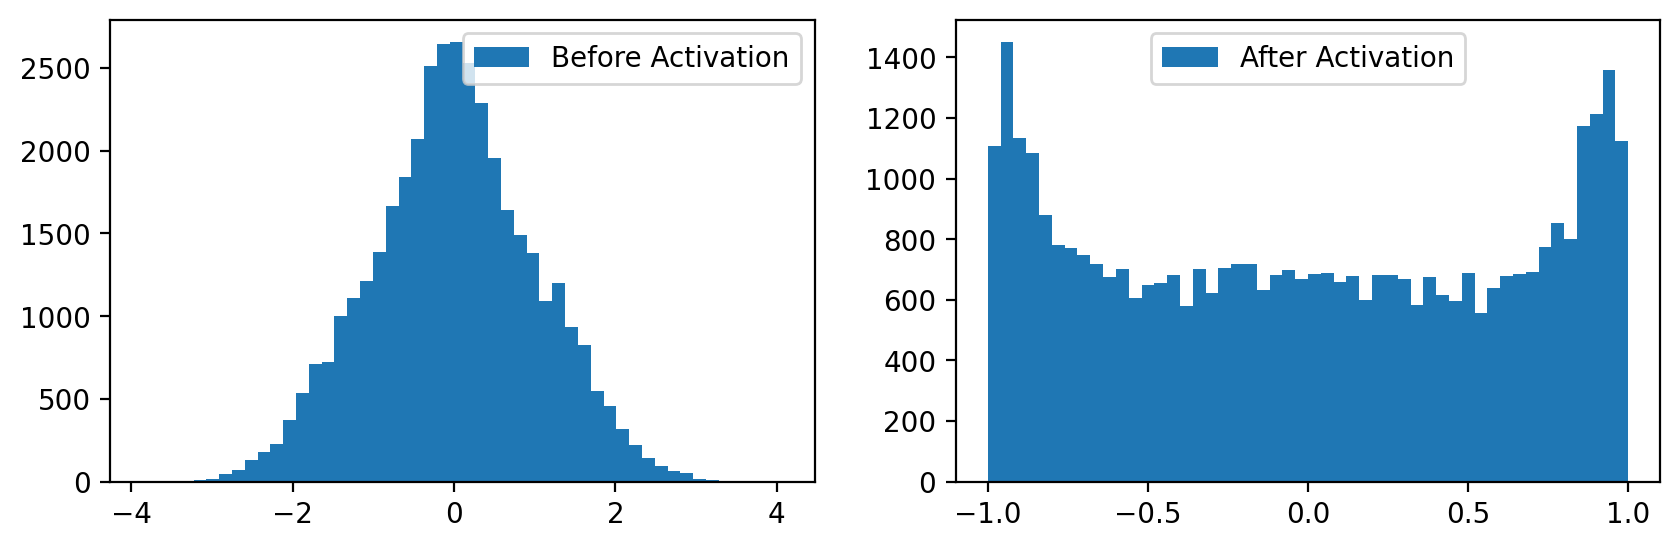

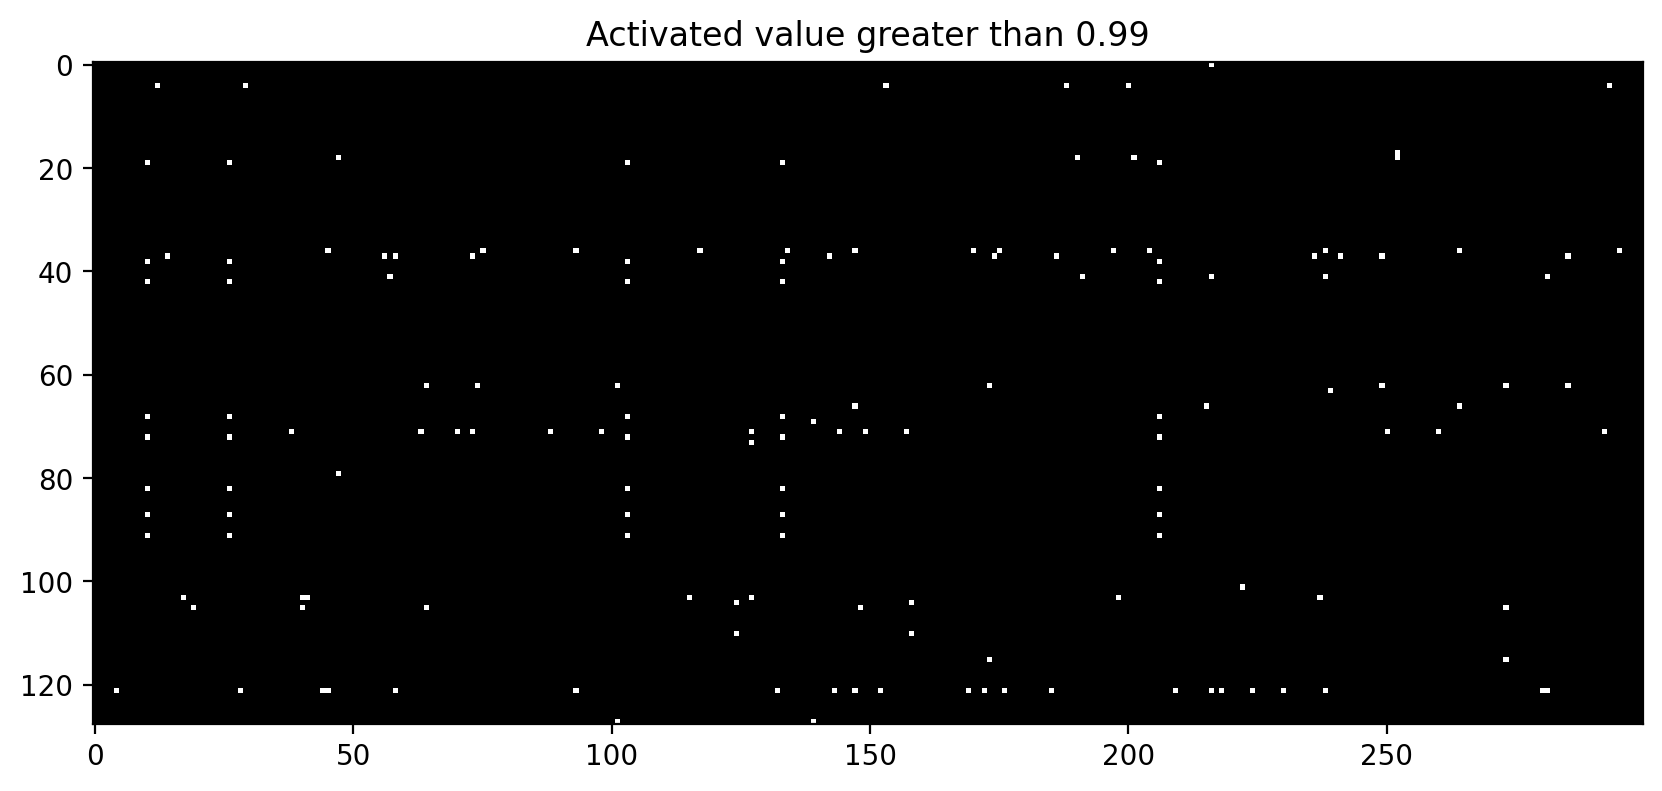

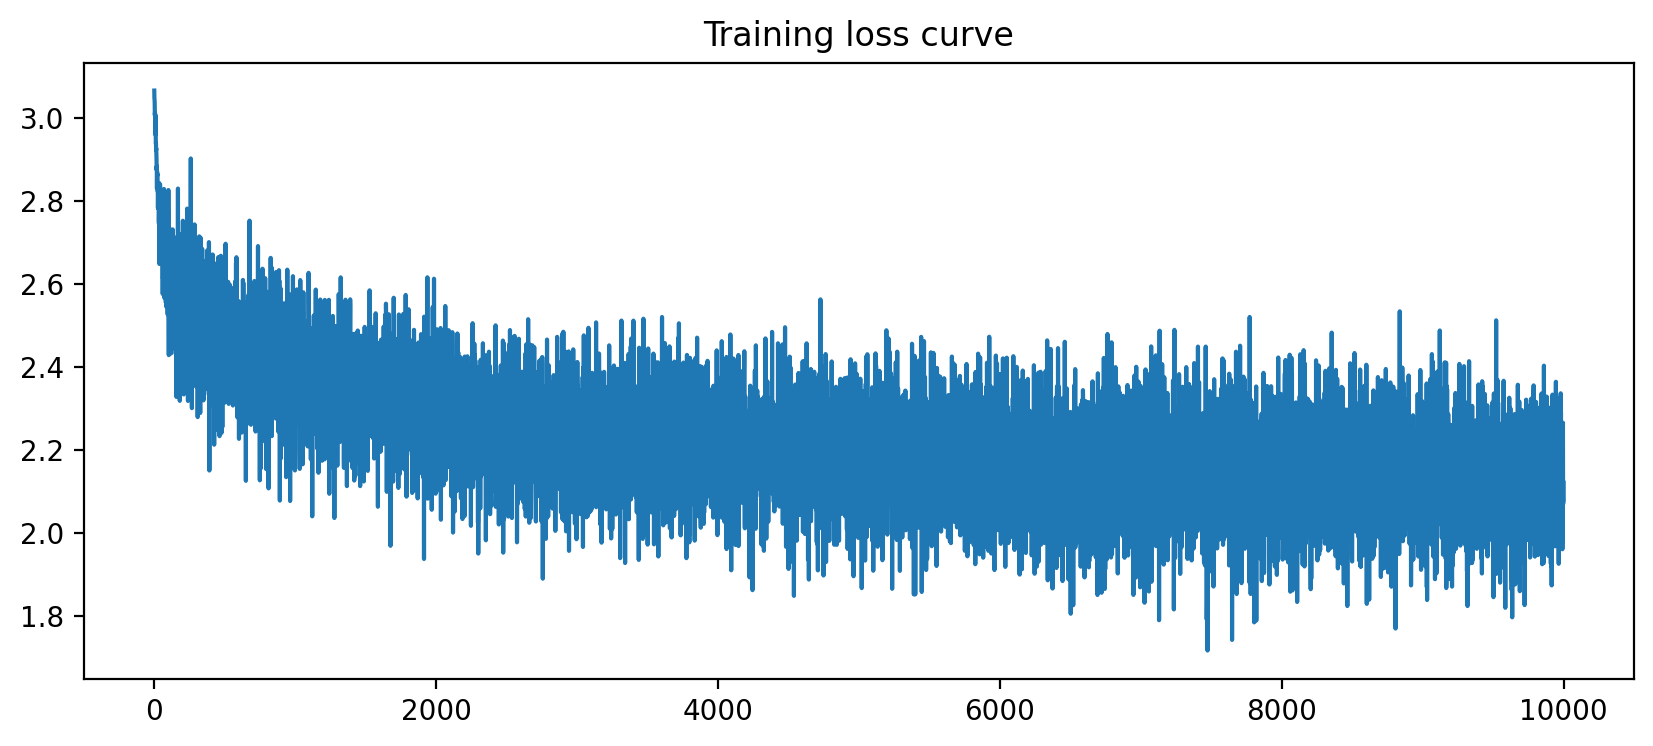

In [87]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.hist(h.view(-1).tolist(), 50, label='Before Activation')
plt.legend()
plt.subplot(122)
plt.hist(h_act.view(-1).tolist(), 50, label='After Activation')
plt.legend()
plt.figure(figsize=(10, 12))
plt.imshow(h_act > 0.99, cmap='gray', interpolation='nearest')
plt.title("Activated value greater than 0.99")
plt.figure(figsize=(10, 4))
plt.plot(track_steps, losses)
plt.title("Training loss curve")
plt.show()

In [88]:
# # Used for find best learning rate
# plt.plot(learning_rates, losses)

#### 3. Validate batch normalization scale values

compare soft-updated batch normalization values during training with directly computed by training datasets

In [89]:
with torch.no_grad():
    embed = C[X_train]
    h = embed.view(-1, window_size * embedding_dim) @ W1 + b1
    bn_mean_train = h.mean(0, keepdim=True)
    bn_std_train = h.std(0, keepdim=True)
    h = bn_gain * ((h - bn_mean_train) / bn_std_train) + bn_bias
    h_act = torch.tanh(h)
    logits = h_act @ W2 + b2
    train_loss = F.cross_entropy(logits, Y_train)
    print(f"Training Loss: {train_loss.item():.3f}")

is_apprv_equal = is_near_equal((bn_std_train - bn_std_running), tensor_value=0.1)
print("Approximately equal" if is_apprv_equal else "Not approximately equal")


Training Loss: 2.125
Approximately equal


### Validation

In [90]:
with torch.no_grad():
    embed = C[X_val]
    h = embed.view(-1, window_size * embedding_dim) @ W1 + b1
    h = bn_gain * ((h - bn_mean_running) / bn_std_running) + bn_bias
    h_act = torch.tanh(h)
    logits = h_act @ W2 + b2
    val_loss = F.cross_entropy(logits, Y_val)
    print(f"Validation Loss: {val_loss.item():.3f}")

Validation Loss: 2.127


### Visualization

visualize embedding layers 1st and 2nd dimensions

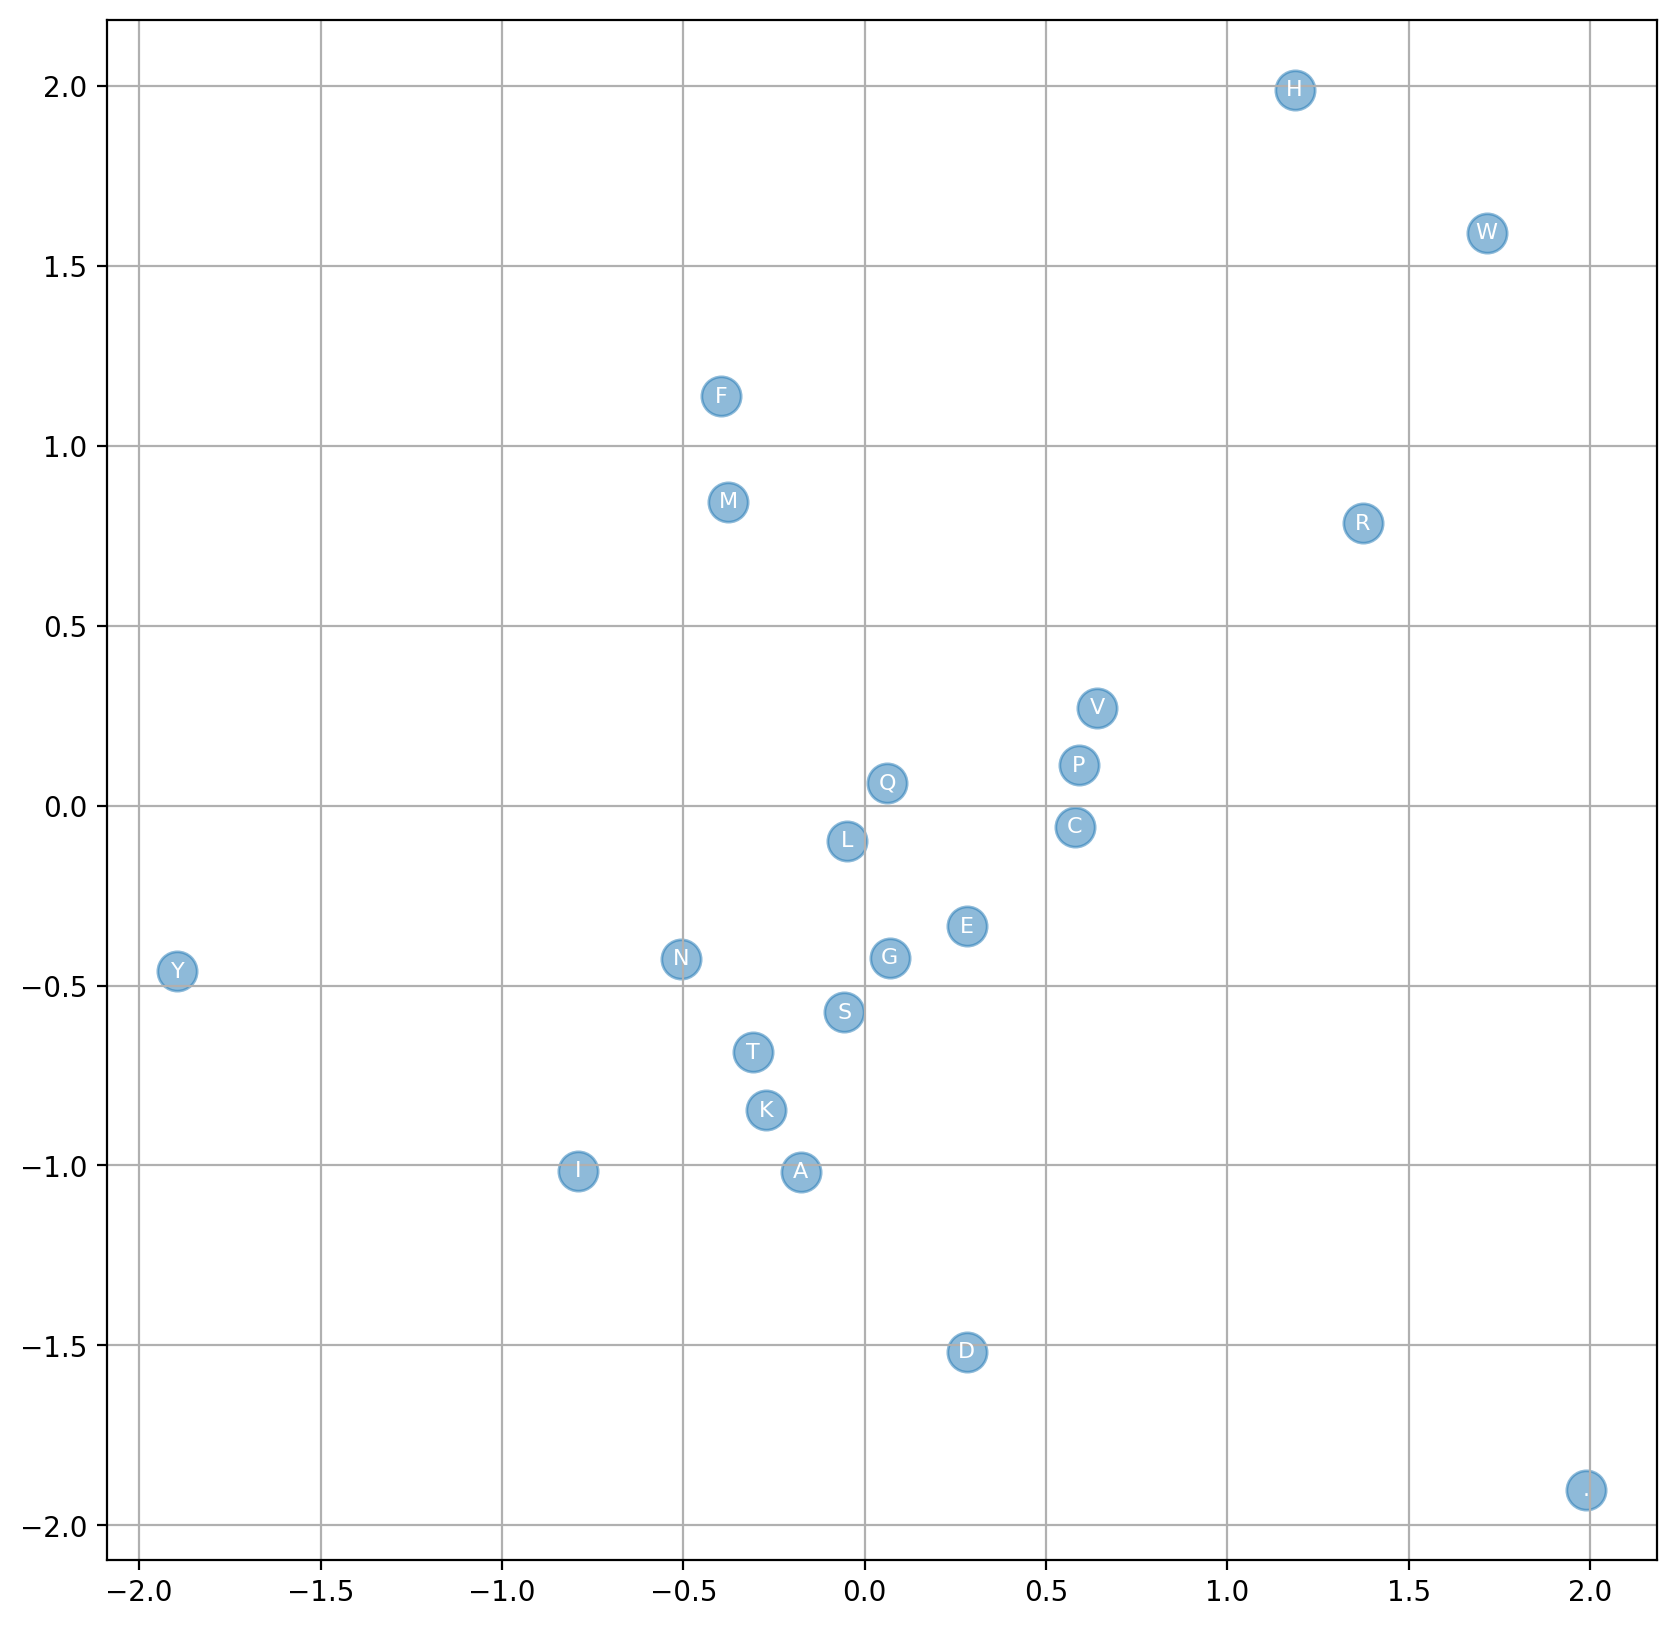

In [91]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200, alpha=0.5)
for i in range(C.shape[0]):
	plt.text(C[i, 0].data, C[i, 1].data, itos[i], ha='center', va='center', color='white', 
		  fontdict={'fontsize': 8})
plt.grid()
plt.show()

### Generate

In [92]:
def sampling_one_seq(start_seq='...', generator=None, end_token='.'):
    sampled_seq = start_seq
    i = 0
    while True:
        with torch.no_grad():
            context_seq = sampled_seq[i:i+window_size]
            input_ids = torch.tensor([stoi[s] for s in context_seq])
            # forward
            embed = C[input_ids]
            h = torch.tanh(embed.view(-1, window_size * embedding_dim) @ W1 + b1)
            logits = h @ W2 + b2
            probs = logits.exp()
            probs /= probs.sum(1, keepdim=True)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
            sampled_seq += itos[ix]
            i += 1
            if ix == stoi[end_token]:
                break
    return sampled_seq[3:-1]

In [93]:
generator = torch.Generator().manual_seed(443)
sampling_one_seq(start_seq='...', generator=generator, end_token='.')

'ARERFAY'

In [94]:
def sampling_batch_seqs(
    sample_size=10, seed=2147483647
):
    generator = torch.Generator().manual_seed(seed)
    sampled_seqs = []

    for i in range(sample_size):
        sampled_seq = sampling_one_seq(start_seq='...', generator=generator, end_token='.')
        sampled_seqs.append(sampled_seq)
    return sampled_seqs

In [95]:
sampling_batch_seqs(sample_size=20)

['ARERGCYAYGPGAISDGFKV',
 'ARQGIWITTIWRWQDPSSTTEVGIVVWDYHYRYMDV',
 'ARKTPGKY',
 'TRQKGLPFDY',
 'ARDRRFTP',
 'ARDLFTR',
 'ARISRSHFDP',
 'AREGWGITCYTPTHELYAWFAF',
 'ATQMDS',
 'ARKGARFQC',
 'ARGYSMDY',
 'TREGEINIVFDS',
 'AREWLARA',
 'ARELPQDF',
 'ARDHGG',
 'ARHRGYYDHDHSPDSTTYYCGATEM',
 'ARDRARVDRSYLMDA',
 'ARASYFSY',
 'ARPLYCRYTFGY',
 'ARYGGARHRAY']

## Summary: Initialization, Activation Statistics, and Batch Normalization

1. **Proper Initialization Matters**
- **Uncalibrated Initializations** can cause very high initial losses (e.g., loss = 20+ instead of the expected ≈3.0 for 21-way classification).
- At initialization, the softmax output should be close to uniform if no prior knowledge exists, leading to a predictable negative log-likelihood loss.
- **Extreme logits** (very large or small numbers) at initialization make the network “confidently wrong,” resulting in poor learning dynamics.

2. **Activation Saturation and Dead Neurons**
- Nonlinearities like **tanh** and **sigmoid** squash their inputs into limited ranges ([-1, 1] or [0, 1]).
    - If preactivations are too large in magnitude, most activations saturate at the extremes, causing **zero gradients** during backpropagation.
    - This leads to “dead neurons” that never update.
- **ReLU** nonlinearities can also suffer from dead neurons if preactivations are always negative.
- Properly scaled initial weights and biases help keep activations in the “active” (non-saturated) regime.

3. **Scaling Weights: The Fan-in Trick**
- The **standard deviation** of weight initialization should be inversely proportional to the square root of the number of input connections (**fan-in**):
    - $$\text{std} = \frac{\text{gain}}{\sqrt{\text{fan-in}}}$$
    - For tanh: gain ≈ 5/3; for ReLU: gain = √2; for linear: gain = 1.
- This ensures that activations (and gradients) neither explode nor vanish as they propagate through layers.

4. **Batch Normalization**
- **BatchNorm** normalizes activations to have zero mean and unit variance across the batch, for each neuron.
- Adds **learnable scale (gamma)** and **shift (beta)** parameters, letting the network adapt the normalized values.
- **During training:** Batch statistics are used.  
  **During inference:** Running averages of mean and variance (computed during training) are used.
- **Benefits:**
    - Makes networks more robust to initialization.
    - Stabilizes and accelerates training, especially for deep networks.
    - Acts as a regularizer due to the noise introduced by batch statistics.
- **Drawbacks:**
    - Couples examples within a batch, which can cause issues for certain tasks and introduces subtle bugs.
    - Has mostly been superseded by alternatives like **LayerNorm** and **GroupNorm** in some architectures.

5. **PyTorch Layer Structure**
- Neural networks are built as **composable modules** (e.g., Linear, BatchNorm1d, Tanh).
- Each module manages its own parameters and buffers (e.g., running means/variances for BatchNorm).
- The forward pass applies layers in sequence, and parameters are updated using gradients from backpropagation.

6. **Diagnostics & Visualization**
- **Histograms of activations**: Check for saturation (many values at the extremes).
- **Gradients**: Should not vanish or explode across layers.
- **Parameter statistics**: Monitor mean, std, and update-to-data ratios.
    - The update-to-data ratio (std of parameter update / std of parameter value) should be around 1e-3 (log10 ≈ -3) for stable training.
- **Learning rate tuning**: If updates are too small/large, adjust the learning rate accordingly.

7. **Takeaways**
- Proper initialization and normalization are crucial for stable and effective training, especially in deep networks.
- BatchNorm greatly reduces sensitivity to initialization and helps train deep nets, but introduces its own quirks.
- Always monitor activation and gradient statistics to diagnose issues early.
- Modern deep learning frameworks (like PyTorch) provide standard modules for these operations—understanding the internals helps with debugging and custom architectures.


**Tip:**  
When building or debugging neural nets:
- Plot activations and gradients.
- Check for dead/saturated neurons.
- Use principled initialization (fan-in, gain).
- Use BatchNorm (or alternatives) where appropriate.
- Tune learning rates based on update-to-data ratios.
